If you aggregate the predictions of a group of predictors(classifiers or regressors), you often get the better predictions than with the best individual predictor. A group of predictors is called an **Ensemble**; thus this technique is called **Ensemble Learning**, and an Ensemble Learning algorithm is called an **Ensemble method**.

# Voting Classifiers
Suppose we have trained a few classifiers, each one achieving about 80% accuracy.

![fig 7-1](images/7-2.png)
## How is that possible?
Suppose you have a slightly biased coin that has a 51% chance of coming up heads, and 49% chance of tails. If you toss it 1000 times, you will generally get more or less 510 heads and 490 tails, and hence a majority of heads. This is due to the **law of large numbers**. 

**If we do the math, we will get the probability of obtaining a majority of heads after 1000 tosses is close to 75%. The more you toss, the higher the probability.**(注意这里的概率说的是抛1000次后得到的结果大多数是头的概率，不是下次抛硬币的概率）

Similarly, suppose we have an ensemble containing 1000 classifiers that are individually correct only 51% of the time. If we predict the majority voted class, we can hope for up to 75% accurracy! **However, this is only true if all classifiers are perfectly independent, making uncorrelated errors, which is clearly not the case since they are trained on the same data. They are likely to make the same types of errors, so there will be majority votes for the wrong class, reducing the ensemble's accuracy.**

**One way to get diverse classifiers is to training them using very different algotithms. This will increase the chance that they will make very different types of errors**.

Here is an example. The training set is the moons dataset(chapter 5)

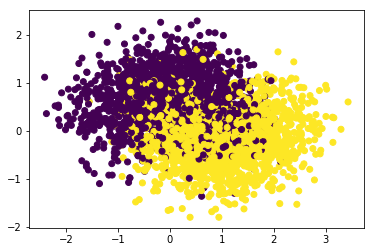

In [1]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
%matplotlib inline
X,y = make_moons(n_samples=3000, noise=0.5, random_state= 10)
plt.scatter(X[:,0],X[:,1],c=y)

In [2]:
from sklearn.cross_validation import train_test_split
X_train,X_test, y_train, y_test =  train_test_split(X,y,test_size=0.3, random_state=0) 

D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
            estimators=[('lr',log_clf),('rf', rnd_clf),('svc', svm_clf)],
            voting='hard')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomF...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [4]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.792222222222
RandomForestClassifier 0.773333333333
SVC 0.812222222222
VotingClassifier 0.802222222222


If all classifiers are able to estimate class probabilities, then we could predict the class with the highest class probility, averaged over all the individual classifiers. This is called **Soft voting**. **It often achieves higher performance than hard voting because it gives more weight to highly confident votes. All we have to do is replace `voting='hard'` with `voting='soft'` and ensure that all classifiers can estimate class probabilities.** And for SVC class, we need to set its `probability` hyperparameter to True. This will make the SVC class use cross-validation to estimate class probabilities, slowing down training, and it will add a `predict_proba()` method.

# Bagging and Pasting
**One way to get a diverse set of classifiers is to use very different training algorithms. Another approach is to use the same training algorithm for every predictor, but to train them on different random subsets of the training set.** 

When sampling is performed with replacement, this method is called **bagging**(bootstrap aggregating). When sampling is performed without replacement, it is called **pasting**.

Both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampledseveral times for the same predictor. See fig 7-4

![fig 7-4](images/7-4.png)
The aggregation function is typically the statistical mode for classification, or the average for regression. Each individual predictor has a higher bias than if it were trained on the original training set, but aggregation reduces both bias and variance. Generally, the net result is that the ensemble has a similar bias but a lower variance than a single predictor trained on the original training set.

# Bagging and Pasting in Scikit-Learn
The follwing code trains an ensemble of 500 Decision Tree classifiers, each trained on 100 training instances randomly sampled from the training set with replacement.(bagging, if you want pasting, set `bootstrap=False`) Then `n_jobs` parameter tells Scikit-Learn the number of CPU cores to use for training and predictions.(-1 tells scikit-learn to use all available cores).

In [5]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
            DecisionTreeClassifier(), n_estimators=500,
            max_samples=100, bootstrap=True, n_jobs=-1)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [6]:
print(accuracy_score(y_test, y_pred))

0.805555555556


![fig 7-5](images/7-5.png)

# Out-of-Bag Evaluation
By default a `BaggingClassifier` samples m training instances with replacement, where m is the size of the training set. This means htat only about 63% of the taining instances are sampled on average for each predictor. The remaining 37% of the training instances that are not sampled are called **out-of-bag(oob)** intances. Note that they are not the same 37% for all predictors.

## How to calculate
NOTE: the proba of any one instace is not sampled for m times is 
$${\lim_{x \to +\infty}{(1-\frac{1}{m})}^m}=\frac{1}{e}=0.368$$

Since a predictor never sees the obb instances during training, It can be evaluated on these instaces. So we can evaluate the ensemble itself by averaging oob evaluations of each predictor.

In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
            DecisionTreeClassifier(), n_estimators=500,
            max_samples=100, bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.82523809523809522

In [8]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.80222222222222217

0.825 and 0.802 is close!

We also could see the probability of each instances.

In [9]:
bag_clf.oob_decision_function_

array([[ 0.06276151,  0.93723849],
       [ 0.10272537,  0.89727463],
       [ 0.06889353,  0.93110647],
       ..., 
       [ 0.82291667,  0.17708333],
       [ 0.91649269,  0.08350731],
       [ 0.2016632 ,  0.7983368 ]])